In [17]:
#pip install leidenalg
import scanpy as sc
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.colors import LinearSegmentedColormap


In [9]:
adata = sc.read("C:/single_cell_fly/ovary.h5ad")

Dimensiones originales: (32412, 12337)
Dimensiones sin células somáticas: (22230, 12337)
Dimensiones del nuevo AnnData (sin somáticas + polígonos): (4648, 12337)


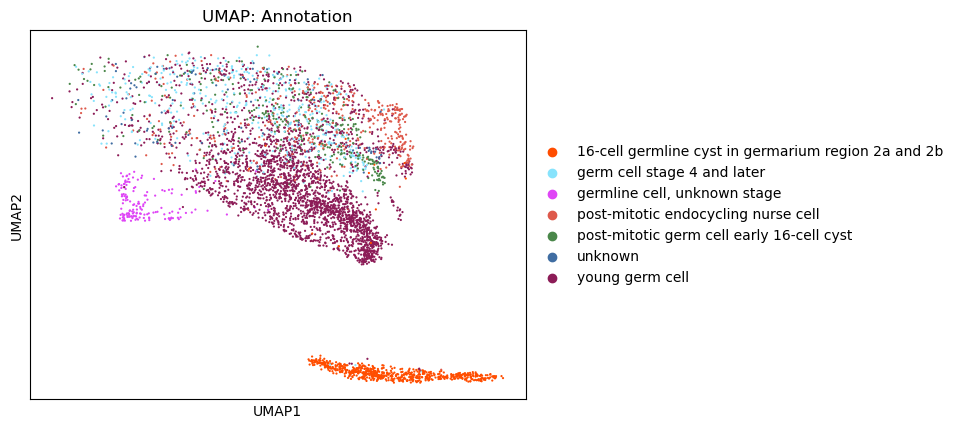

C:\Users\omcn8\AppData\Local\Temp\ipykernel_31020\391678217.py:166: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


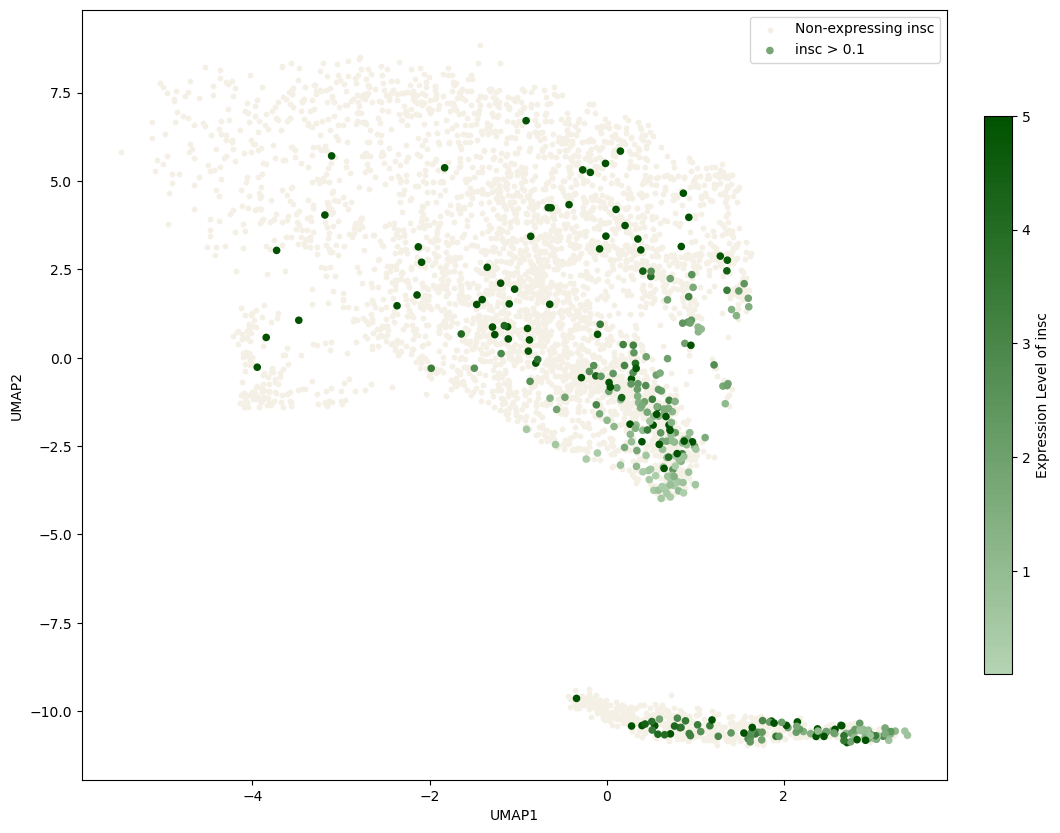

Gráfico guardado en umap_insc_expression_custom.pdf


In [29]:
# ---------------------------------------------------------------------
# Step 0: Removing somatic annotations from the original object
# ---------------------------------------------------------------------
somatic_annotations = [
    "stretch follicle cell",
    "stalk follicle cell",
    "dorsal appendage forming follicle cell",
    "adult tracheal cell",
    "oviduct",
    "ovarian sheath muscle",
    "artefact"
]

mask_somatic = adata.obs["annotation"].isin(somatic_annotations)
adata_no_somatic = adata[~mask_somatic].copy()
print(f"Dimensiones originales: {adata.shape}")
print(f"Dimensiones sin células somáticas: {adata_no_somatic.shape}")

# ---------------------------------------------------------------------
# Step 1: Preparation of data and UMAP (we work with adata_no_somatic)
# ---------------------------------------------------------------------
umap_coords = adata_no_somatic.obsm['X_umap']

# Define coordinates of the rhombus
vertices_rombo = np.array([
    [1, -5],
    [-5, -2.5],
    [-7.5, 13],
    [5, 6]
])

# Define pentagon coordinates
vertices_pentagono = np.array([
    [4, -15],
    [-3, -10],
    [0, -7],
    [4, -10.5]
])

# ---------------------------------------------------------------------
# Step 2: Selecting cells within both polygons
# ---------------------------------------------------------------------
path_rombo = Path(vertices_rombo)
mask_rombo = path_rombo.contains_points(umap_coords)

path_pentagono = Path(vertices_pentagono)
mask_pentagono = path_pentagono.contains_points(umap_coords)

selected_cells_rombo = np.where(mask_rombo)[0]
selected_cells_pentagono = np.where(mask_pentagono)[0]

# Unite indexes of both regions
selected_cells = np.union1d(selected_cells_rombo, selected_cells_pentagono)

# Create AnnData with selected cells
adata_subset = adata_no_somatic[selected_cells].copy()
print(f"Dimensiones del nuevo AnnData (sin somáticas + polígonos): {adata_subset.shape}")

# ---------------------------------------------------------------------
# Step 3: Map indices to identify rhombus and pentagon
# ---------------------------------------------------------------------
index_mapping = {
    original_idx: subset_idx
    for subset_idx, original_idx in enumerate(selected_cells)
}
selected_cells_rombo_subset = [
    index_mapping[idx] for idx in selected_cells_rombo if idx in index_mapping
]
selected_cells_pentagono_subset = [
    index_mapping[idx] for idx in selected_cells_pentagono if idx in index_mapping
]

# Create 'polygon' column to know the origin
adata_subset.obs['polygon'] = 'None'
adata_subset.obs.iloc[selected_cells_rombo_subset, adata_subset.obs.columns.get_loc('polygon')] = 'Rombo'
adata_subset.obs.iloc[selected_cells_pentagono_subset, adata_subset.obs.columns.get_loc('polygon')] = 'Pentágono'

# ---------------------------------------------------------------------
# Step 4: Visually verify the annotation (optional)
# ---------------------------------------------------------------------
# Make sure that “annotation” is categorical
adata_subset.obs["annotation"] = adata_subset.obs["annotation"].astype("category")

# Manual mapping: annotation -> color (hex)
# Set the colors you want for each category
annotation_colors_map = {
    "16-cell germline cyst in germarium region 2a and 2b": "#FF4D00",
    "germ cell stage 4 and later": "#87E3FC",
    "germline cell, unknown stage": "#DF45F6", 
    "post-mitotic endocycling nurse cell": "#DE594B",
    "post-mitotic germ cell early 16-cell cyst": "#4A874A",
    "unknown": "#406DA2",                                             
    "young germ cell": "#8C1C57",                                      
}

# We get the current order of categories in adata_subset
annotation_cats = adata_subset.obs["annotation"].cat.categories

# For each category, we assign the color defined in annotation_colors_map.
# If there is a category that is not in the dictionary, it is given a default color (e.g. gray).
assigned_colors = []
for cat in annotation_cats:
    if cat in annotation_colors_map:
        assigned_colors.append(annotation_colors_map[cat])
    else:
        assigned_colors.append("#808080")  # default color for unmapped categories

# We store these colors in the key “annotation_colors”.
adata_subset.uns["annotation_colors"] = assigned_colors

# Finally, we plot the UMAP
sc.pl.umap(
    adata_subset,
    color="annotation",
    title="UMAP: Annotation",
    legend_loc="right margin",  # To place the legend in the right margin
    size=10 # Adjust the size of the dots
)

# ---------------------------------------------------------------------
# Step 5: Configure the color palette for insc (light green to dark green)
# ---------------------------------------------------------------------
colors = ["#b4d3b2", "#005200"]
n_bins = 100
cmap_name = 'light_to_dark_green'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# ---------------------------------------------------------------------
# Step 6: Obtaining the expression of the 'insc' gene
# ---------------------------------------------------------------------
def get_insc_expression(adata_obj):
    if adata_obj.raw is not None and 'insc' in adata_obj.raw.var_names:
        expr = adata_obj.raw[:, adata_obj.raw.var_names == 'insc'].X
        if hasattr(expr, "toarray"):
            expr = expr.toarray().flatten()
    elif 'insc' in adata_obj.var_names:
        expr = adata_obj[:, adata_obj.var_names == 'insc'].X
        if hasattr(expr, "toarray"):
            expr = expr.toarray().flatten()
    else:
        raise ValueError("El gen 'insc' no se encuentra en el dataset.")
    return expr

insc_expression = get_insc_expression(adata_subset)

# Threshold for defining expressor vs. non-expressor cells
threshold = 0.1
non_expressing_cells = insc_expression <= threshold
expressing_cells = insc_expression > threshold

# ---------------------------------------------------------------------
# Step 7: Display the insc expression with the same colors and sizes
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 10))

# UMAP coordinates of the subset
umap_coords_subset = adata_no_somatic.obsm['X_umap'][selected_cells]

# Cells without expression of insc (bone color)
ax.scatter(
    umap_coords_subset[non_expressing_cells, 0],
    umap_coords_subset[non_expressing_cells, 1],
    c=(0.96, 0.94, 0.90),
    s=10,
    label="Non-expressing insc"
)

# Cells with expression of insc (light green -> dark green)
scatter = ax.scatter(
    umap_coords_subset[expressing_cells, 0],
    umap_coords_subset[expressing_cells, 1],
    c=insc_expression[expressing_cells],
    cmap=cm,
    s=20,
    vmin=0.1,
    vmax=5,
    label="insc > 0.1"
)

# Color bar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Expression Level of insc')

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(loc='upper right')

plt.savefig('umap_insc_expression_custom.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico guardado en umap_insc_expression_custom.pdf")
